In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

In [2]:
dataset_path = "../../dataset"
preprocessed_dataset_path = f"{dataset_path}/preprocessed_dataset/"

In [3]:
from codes.docs.analysis import data_preprocessing
from codes.docs.analysis.gene_analysis import genetic_file_preprocess

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import glob
from collections import defaultdict
%matplotlib inline

Notebook 1 description: 
1. Imaging data is imported and preprocessed

Available informations
- Volumetric dataset (dHCP) - 675 individuals
- Diffusion dataset - 432 individuals
- Microstructure - 318 individuals
- Cortical thickness - 234 individuals
2. Genetic data is added and outliers removed
- ASD - PRS calculated from GWAS (2019)[Grove et al., 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6454898/)

## Merging all data with PRS scores

- PRS file contains PRS at 11 P-value thresholds, which ranges from 1e-8 to 1.
- The Ancestry files contains the first 10 PCs of the genetic data
- The data can be divided into 3 different ethnic groups: European, South Asian and African
- The outliers are removed to each cohort separately (i.e., European, European + South Asian (called mixed cohort), and European + South Asian + Africans (called full cohort)

In [23]:
# change the release number accordingly
full_dataset = pd.read_csv(
    f'{preprocessed_dataset_path}/imaging_data/log_file/combined_imaging_full_dataset_release2.csv',
    index_col=[0])

### batch 1 genetics

In [24]:
pheno = 'asd'
european_cohort = genetic_file_preprocess.Cohort(
    cohort_name='euro',
    PRS_file_path=
    f'{dataset_path}/PRS/{pheno}/ASD_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',
    Ancestry_file_path=
    f'{dataset_path}/ancestry_PCs/file3_only_europ_pca.eigenvec',
    imaging_df=full_dataset)
mixed_cohort = genetic_file_preprocess.Cohort(
    cohort_name='mixed',
    PRS_file_path=
    f'{dataset_path}/PRS/{pheno}/ASD_eurold_lifted37_dHCP_merged_cleaned_EUROPEAN_ASIAN.gwas.all.score',
    Ancestry_file_path=
    f'{dataset_path}/ancestry_PCs/euro_asian_361_file3_pca.eigenvec',
    imaging_df=full_dataset)
full_cohort = genetic_file_preprocess.Cohort(
    cohort_name='full',
    PRS_file_path=
    f'{dataset_path}/PRS/{pheno}/ASD_eurold_lifted37_dHCP_merged_cleaned_FULL.gwas.all.score',
    Ancestry_file_path=f'{dataset_path}/ancestry_PCs/file3_all_pca.eigenvec',
    imaging_df=full_dataset)

In [25]:
#european_ID and asian_ID
european_ID = european_cohort.cohort_data.ID.tolist()
asian_ID = [
    i for i in mixed_cohort.cohort_data.ID.tolist()
    if i not in european_ID
]
african_ID = [
    i for i in full_cohort.cohort_data.ID.tolist()
    if (i not in european_ID) and (i not in asian_ID)
]
cohort_list = pd.DataFrame({'ID':full_cohort.cohort_data.ID.tolist(),
             'cohort':['EUR' if i in european_ID else 'ASI' if i in asian_ID else 'AFR' for i in full_cohort.cohort_data.ID.tolist()]})

european_cohort.append_cohort_list(cohort_list)
mixed_cohort.append_cohort_list(cohort_list)
full_cohort.append_cohort_list(cohort_list)

In [28]:
mixed_cohort.volumetric_df

,ID,Session,17 ICV (all except bone),17 TOTAL BRAIN TISSUE VOLUME (mm3),"19 Volume Pallidum (Bilateral) AAL, careful with preterm","28 Volume Mesencephalon (right cerebellum) (AAL, careful with preterm!)","28 Volume Mesencephalon (left cerebellum) (AAL, careful with preterm!)","28 Volume Mesencephalon (vermis) (AAL, careful with preterm!)","30 Volume Right Putamen (AAL, careful with preterm!)","30 Volume Left Putamen (AAL, careful with preterm!)",...,mixed_Anc_PC93,mixed_Anc_PC94,mixed_Anc_PC95,mixed_Anc_PC96,mixed_Anc_PC97,mixed_Anc_PC98,mixed_Anc_PC99,mixed_Anc_PC100,termness,cohort
415,CC00832XX16,630,510101.250,434398.000,1634.375,11314.750,11151.500,3004.625,2389.250,2298.000,...,0.031847,-0.054909,-0.003212,-0.006587,-0.018962,0.123261,-0.109261,-0.052005,term,ASI
377,CC00749XX24,2600,517132.000,425957.875,1457.375,12763.125,12213.750,3459.125,2172.500,2120.750,...,-0.015666,0.005008,0.011371,-0.012353,-0.008286,0.044054,-0.031802,0.011934,term,EUR
408,CC00818XX18,4020,495226.750,412848.375,1458.875,11586.625,10824.875,3032.875,2117.750,2024.875,...,-0.088747,0.047356,-0.058089,-0.038885,-0.036723,0.092708,-0.027718,-0.068852,term,EUR
406,CC00815XX15,4120,454489.000,381684.875,1337.125,10101.500,9245.125,2742.250,1901.500,1802.875,...,-0.000534,0.041674,0.018496,0.001137,0.041838,-0.020747,0.049967,-0.045737,term,EUR
381,CC00766XX16,4200,442639.375,360125.000,1335.375,10410.125,9897.625,2848.625,1812.250,1772.125,...,-0.021731,-0.022328,0.039164,-0.013004,-0.012827,0.026390,0.013396,-0.006555,term,EUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,CC00713XX12,229000,550776.125,434524.125,1653.125,11838.125,11960.750,3511.250,2393.375,2390.875,...,0.012927,-0.046492,0.017185,-0.005267,0.065286,-0.043826,-0.021617,-0.020366,term,EUR
371,CC00740XX15,238400,507580.625,407956.000,1489.000,11371.875,11533.250,3620.875,2301.125,2183.500,...,0.044953,-0.003056,0.007928,-0.061720,0.012158,0.037721,-0.114801,0.021996,term,EUR
387,CC00777XX19,239102,500955.500,420747.125,1664.000,10856.875,10255.625,2783.500,2456.375,2302.625,...,-0.019842,0.038789,0.091680,-0.086846,0.031028,0.077400,-0.185657,-0.093330,term,EUR
362,CC00714XX13,240900,416210.000,345665.500,1337.750,9357.125,9332.125,2853.875,1866.500,1833.125,...,0.045901,-0.017963,0.019471,0.015062,0.009848,-0.016397,-0.020659,-0.012734,term,ASI


### batch 2 genetics

In [50]:
full_dataset = full_dataset.rename(columns={'GA_micro':'GA','PMA_micro':'PMA','Session_vol':'Session'})

In [51]:
pheno = 'asd'
european_cohort = genetic_file_preprocess.Cohort(
    cohort_name='euro',
    PRS_file_path=
    f'{dataset_path}/PRS/{pheno}/ASD_nodups_euro_batch2_genotyped.gwas.all_score',
    Ancestry_file_path=
    f'{dataset_path}/ancestry_PCs/euro_batch2_genotyped_PCA_result.eigenvec',
    imaging_df=full_dataset)


In [52]:
european_cohort.cohort_data['cohort'] = 'EUR'

### saving full dataset

In [18]:
pd.pivot_table(european_cohort_batch2.cohort_data,
               values=['GA_vol','PMA_vol'],
               index=['cohort','termness'],
               aggfunc={'cohort':np.count_nonzero,
                        'GA_vol':np.mean,
                        'PMA_vol':np.mean})

GA_vol    PMA_vol  cohort
cohort termness                                          
EUR    preterm               33.000000  34.702381      14
       preterm/term_at_scan  31.875576  36.723502      63
       term                  40.114286  41.628000     257

In [12]:
pd.pivot_table(full_cohort.cohort_data,
               values=['GA_vol','PMA_vol'],
               index=['cohort','termness'],
               aggfunc={'cohort':np.count_nonzero,
                        'GA_vol':np.mean,
                        'PMA_vol':np.mean})

GA_vol    PMA_vol  cohort
cohort termness                                          
AFR    preterm               33.297619  35.238095      12
       preterm/term_at_scan  30.118227  35.532020      29
       term                  39.876424  40.744084     163
ASI    preterm               32.214286  34.142857       2
       preterm/term_at_scan  33.571429  35.632653       7
       term                  40.042553  41.364742      47
EUR    preterm               32.857143  34.610390      13
       preterm/term_at_scan  31.849351  36.688312      56
       term                  40.079515  41.522237     219

In [111]:
full_cohort.cohort_data.to_csv(f'{preprocessed_dataset_path}/imaging_data/log_file/combined_imaging_genetic_pre_outliers_full_dataset.csv')

In [11]:
# full_dataset.drop(columns=['Session_vol','Session_diff'],inplace=True)
# full_dataset = data_preprocessing.move_multiple_columns(full_dataset,cols_to_move=['Gender','GA_diff','PMA_diff'],ref_col='ID',place='After')

### Removing outliers

Outlier is defined using the Anc PCs. Should I do the this for each dataset or all of them together? Note that the ancestry components for european cohort alone is different from ancestry PCs for european from european and asian cohort mixed

In [26]:
european_cohort.volumetric_df = european_cohort.extract_neonates_data(columns=['Imperial 1','termness'],criteria={'termness':'term'},remove_duplicates=True) # other options = preterm/term_at_scan
mixed_cohort.volumetric_df = mixed_cohort.extract_neonates_data(columns=['Imperial 1','termness'],criteria={'termness':'term'},remove_duplicates=True) # other options = preterm/term_at_scan
full_cohort.volumetric_df = full_cohort.extract_neonates_data(columns=['Imperial 1','termness'],criteria={'termness':'term'},remove_duplicates=True) # other options = preterm/term_at_scana

In [27]:
print('available number of subjects in each dataset before removing outliers')
pd.DataFrame({
    'Dataset': ['Vol'],
    'euro_number': [
        european_cohort.volumetric_df.shape[0],
#         european_cohort.diffusion_df.shape[0],
#         european_cohort.micro_df.shape[0]]
    ],
    'mixed_number': [
        mixed_cohort.volumetric_df.shape[0],
#         mixed_cohort.diffusion_df.shape[0],
#         mixed_cohort.micro_df.shape[0]
    ],
#     'full_number': [
#         full_cohort.volumetric_df.shape[0],
#         full_cohort.diffusion_df.shape[0],
#         full_cohort.micro_df.shape[0]
#     ]
})

available number of subjects in each dataset before removing outliers


,Dataset,euro_number,mixed_number
0,Vol,211,258


Outliers are defined if they have more than 3.5 standard deviation on the AncPC2 and AncPC3

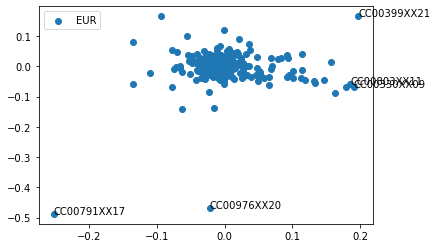

In [12]:
european_cohort.volumetric_df, _ = genetic_file_preprocess.Cohort.remove_outliers(
    european_cohort.volumetric_df,
    to_examine=['euro_Anc_PC2', 'euro_Anc_PC3'],hue='cohort',
    to_annotate='ID')

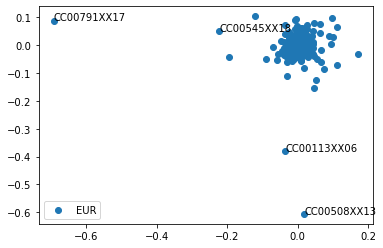

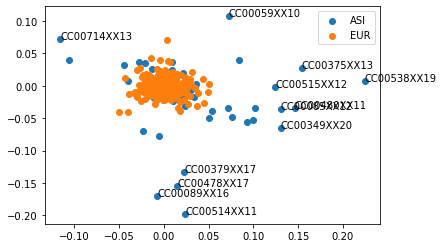

In [18]:
european_cohort.volumetric_df, _ = genetic_file_preprocess.Cohort.remove_outliers(
    european_cohort.volumetric_df,
    to_examine=['euro_Anc_PC2', 'euro_Anc_PC3'],hue='cohort',
    to_annotate='ID')

mixed_cohort.volumetric_df, _ = genetic_file_preprocess.Cohort.remove_outliers(
    mixed_cohort.volumetric_df,
    to_examine=['mixed_Anc_PC4', 'mixed_Anc_PC5'],hue='cohort',
    to_annotate='ID')

# full_cohort.volumetric_df, _ = genetic_file_preprocess.Cohort.remove_outliers(
#     full_cohort.volumetric_df,
#     to_examine=['full_Anc_PC7', 'full_Anc_PC8'],hue='cohort',
#     to_annotate='ID')

In [20]:
mixed_cohort.volumetric_df

,Session,Imperial 1,Imperial 2,Imperial 3,Imperial 4,Imperial 5,Imperial 6,Imperial 7,Imperial 8,Imperial 9,...,mixed_Anc_PC93,mixed_Anc_PC94,mixed_Anc_PC95,mixed_Anc_PC96,mixed_Anc_PC97,mixed_Anc_PC98,mixed_Anc_PC99,mixed_Anc_PC100,termness,cohort
ID,,,,,,,,,,,,,,,,,,,,,
CC00832XX16,630,832.375,912.125,581.500,693.500,1067.000,1133.375,1260.875,1189.625,1352.875,...,0.031847,-0.054909,-0.003212,-0.006587,-0.018962,0.123261,-0.109261,-0.052005,term,ASI
CC00749XX24,2600,909.125,844.375,560.625,644.500,1171.375,1174.125,1250.500,1289.000,1019.500,...,-0.015666,0.005008,0.011371,-0.012353,-0.008286,0.044054,-0.031802,0.011934,term,EUR
CC00818XX18,4020,814.250,901.500,511.500,619.625,1100.125,1104.500,1023.250,1239.625,1315.125,...,-0.088747,0.047356,-0.058089,-0.038885,-0.036723,0.092708,-0.027718,-0.068852,term,EUR
CC00815XX15,4120,732.000,831.250,458.500,542.250,998.750,1038.250,958.625,969.125,1446.250,...,-0.000534,0.041674,0.018496,0.001137,0.041838,-0.020747,0.049967,-0.045737,term,EUR
CC00766XX16,4200,744.375,833.250,470.125,503.500,833.875,883.625,796.250,920.375,1091.625,...,-0.021731,-0.022328,0.039164,-0.013004,-0.012827,0.026390,0.013396,-0.006555,term,EUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC00685XX18,226100,668.125,839.125,506.375,600.625,901.875,1030.125,896.625,1047.000,1191.375,...,-0.034236,-0.031677,0.032668,0.000395,-0.003865,-0.050248,0.071723,-0.009880,term,EUR
CC00713XX12,229000,1022.500,939.375,636.625,701.000,900.250,1125.125,1048.125,1033.375,1339.750,...,0.012927,-0.046492,0.017185,-0.005267,0.065286,-0.043826,-0.021617,-0.020366,term,EUR
CC00740XX15,238400,1008.875,891.375,462.125,601.375,1058.375,1110.000,1225.750,1139.250,1098.875,...,0.044953,-0.003056,0.007928,-0.061720,0.012158,0.037721,-0.114801,0.021996,term,EUR


### saving preprocessed data without outliers

In [12]:
european_cohort.diffusion_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/diffusion/term/european_diffusion_df.csv')
# mixed_cohort.diffusion_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/diffusion/term/mixed_diffusion_df.csv')
# full_cohort.diffusion_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/diffusion/term/full_diffusion_df.csv')

# european_volumetric_term_dataset.to_csv('./preprocessed_data/volumetric/term/european_volumetric_term_dataset.csv',index=False)
# european_microstructure_term_dataset.to_csv('./preprocessed_data/microstructure/term/european_microstructure_term_dataset.csv',index=False)


# mixed_diffusion_term_dataset.to_csv('./preprocessed_data/diffusion/term/mixed_diffusion_term_dataset.csv',index=False)
# mixed_volumetric_term_dataset.to_csv('./preprocessed_data/volumetric/term/mixed_volumetric_term_dataset.csv',index=False)
# mixed_microstructure_term_dataset.to_csv('./preprocessed_data/microstructure/term/mixed_microstructure_term_dataset.csv',index=False)

# full_cohort_diffusion_term_dataset.to_csv('./preprocessed_data/diffusion/term/full_cohort_diffusion_term_dataset.csv',index=False)
# full_cohort_volumetric_term_dataset.to_csv('./preprocessed_data/volumetric/term/full_cohort_volumetric_term_dataset.csv',index=False)
# full_cohort_microstructure_term_dataset.to_csv('./preprocessed_data/microstructure/term/full_cohort_microstructure_term_dataset.csv',index=False)


In [19]:
european_cohort.volumetric_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/volumetric/preterm/european_volumetric_df.csv')
# mixed_cohort.volumetric_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/volumetric/term/mixed_volumetric_df.csv')

In [17]:
mixed_cohort.volumetric_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/volumetric/term/mixed_volumetric_df.csv')

In [11]:
european_cohort_batch2.volumetric_df.to_csv(f'{preprocessed_dataset_path}/imaging_data/volumetric/term/european_volumetric_df_batch2.csv')

In [22]:
mixed_cohort.volumetric_df.to_csv(f'{preprocessed_dataset_path}/asd/rel3_batch1/volumetric/mixed_cohort_term_volumetric_rel3_batch1.csv')